<h1 align="center" style="font-weight: bold; font-size: 48px;">Rotten Tomatoes - Audience Rating Prediction</h1>



<img src="https://www.rottentomatoes.com/assets/pizza-pie/images/rottentomatoes_logo_40.336d6fe66ff.png" alt="Rotten Tomatoes">


## **Author**

James Jeberson M - jamesjebersonm@gmail.com

# **Importing required libraties**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# **Loading the Dataset**

In [2]:
rt_df = pd.read_excel("Rotten_Tomatoes_Movies3.xls")

# **Data preprocessing**

In [3]:
# dropping the duplicated row
rt_df = rt_df.drop_duplicates() 

########################################################################################################

# fixing typo in dataset
rt_df['rating'] = rt_df['rating'].replace({'PG-13)': 'PG-13', 'R)': 'R'})

########################################################################################################

# dropping columns with missing values in audience_rating
rt_df = rt_df.dropna(subset=['audience_rating']) 

########################################################################################################

# mean imputation
rt_df['runtime_in_minutes']=rt_df['runtime_in_minutes'].fillna(rt_df['runtime_in_minutes'].mean()) 
# median imputation
for col in ['in_theaters_date', 'on_streaming_date']: 
    rt_df[col]=rt_df[col].fillna(rt_df[col].median())

########################################################################################################

# transforming 'critics_consensus' column
def classify_sentiment(text):
    if pd.isnull(text):
        return 'Unknown'
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'
rt_df['critics_sentiment'] = rt_df['critics_consensus'].apply(classify_sentiment)

# Dropping 'critics_consensus' column
rt_df = rt_df.drop(columns=['critics_consensus'])

########################################################################################################

# Fill missing values in text columns with placeholders
rt_df['movie_info'] = rt_df['movie_info'].fillna('Unknown')
rt_df['genre'] = rt_df['genre'].fillna('Unknown Genre')
rt_df['directors'] = rt_df['directors'].fillna('Unknown Director')
rt_df['writers'] = rt_df['writers'].fillna('Unknown Writer')
rt_df['cast'] = rt_df['cast'].fillna('Unknown Cast')
rt_df['studio_name'] = rt_df['studio_name'].fillna('Unknown Studio')

# **Feature Encoding**

In [4]:
# Encoding Dates into day, month and year

# Encoding in_theaters_date
rt_df['in_theaters_day'] = rt_df['in_theaters_date'].dt.day
rt_df['in_theaters_month'] = rt_df['in_theaters_date'].dt.month
rt_df['in_theaters_year'] = rt_df['in_theaters_date'].dt.year

# Encoding on_streaming_date
rt_df['on_streaming_day'] = rt_df['on_streaming_date'].dt.day
rt_df['on_streaming_month'] = rt_df['on_streaming_date'].dt.month
rt_df['on_streaming_year'] = rt_df['on_streaming_date'].dt.year

########################################################################################################

# OneHot encoding 'rating', 'tomatometer_status' & 'critics_sentiment'
rt_df = pd.get_dummies(rt_df, columns=['rating', 'tomatometer_status', 'critics_sentiment'])

# Replacing True & False with 1 & 0
rt_df = rt_df.replace({True: 1, False: 0})

########################################################################################################

# Encoding 'genre' column
genre_lists = rt_df['genre'].apply(lambda x: [i.strip() for i in str(x).split(',')])

mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(genre_lists), columns=mlb.classes_, index=rt_df.index)

rt_df = pd.concat([rt_df, genre_encoded], axis=1).drop(columns=['genre'])

########################################################################################################

# encoding directors, writers, cast & studio_name
def frequency_encode(column):

    all_values = [value.strip() for item in column for value in str(item).split(',')]
    frequency = pd.Series(all_values).value_counts()
    return column.apply(lambda x: sum(frequency.get(value.strip()) for value in str(x).split(',')))

rt_df['directors_freq'] = frequency_encode(rt_df['directors'])
rt_df['writers_freq'] = frequency_encode(rt_df['writers'])
rt_df['cast_freq'] = frequency_encode(rt_df['cast'])
rt_df['studio_name_freq'] = frequency_encode(rt_df['studio_name'])

# replaceing frequency of unknown values with 0
rt_df.loc[rt_df['directors'] == 'Unknown Director', 'directors_freq'] = 0
rt_df.loc[rt_df['directors'] == 'Unknown Writer', 'writers'] = 0
rt_df.loc[rt_df['directors'] == 'Unknown Cast', 'cast'] = 0
rt_df.loc[rt_df['directors'] == 'Unknown Studio', 'studio_name'] = 0

########################################################################################################

# dropping columns
rt_df.drop(columns = {'in_theaters_date', 'on_streaming_date', 'movie_title', 'movie_info', 'directors', 'writers', 'cast', 'studio_name'}, inplace=True)

# **Train Test Split**

In [6]:
# splitting dataset to train and test datasets

X = rt_df.drop(columns = 'audience_rating')
y = rt_df['audience_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# **CatBoost Regressor**

In [7]:
# Initialize CatBoost Regressor 
catboost_reg = CatBoostRegressor(iterations=200, depth=8, learning_rate=0.1, verbose=0, random_state=42)

# Training the model
catboost_reg.fit(X_train, y_train)

# predicting on test data
y_pred = catboost_reg.predict(X_test)

# **Model Evaluation**

In [8]:
print(f"Root Mean Squared Error: {root_mean_squared_error(y_test, y_pred):.2f}")
print(f"R Squared: {r2_score(y_test, y_pred):.2f}")

Root Mean Squared Error: 13.11
R Squared: 0.59


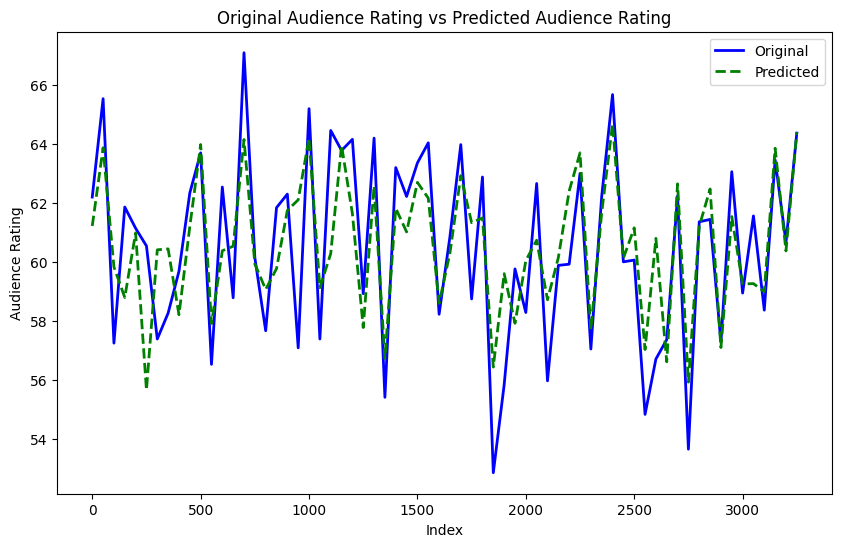

In [9]:
# Plotting Original vs Predicted values (CatBoost Regressor)
df = pd.DataFrame({
    'Index': np.arange(len(y_test)),
    'Original': y_test,
    'Predicted': catboost_reg.predict(X_test)
})

df['Bucket'] = (df['Index'] // 50) * 50
bucketed_df = df.groupby('Bucket').agg({'Original': 'mean', 'Predicted': 'mean'}).reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=bucketed_df, x='Bucket', y='Original', label='Original', color='blue', linewidth=2)
sns.lineplot(data=bucketed_df, x='Bucket', y='Predicted', label='Predicted', color='green', linestyle='--', linewidth=2)

plt.xlabel('Index')
plt.ylabel('Audience Rating')
plt.title('Original Audience Rating vs Predicted Audience Rating')
plt.legend()

plt.show()